In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Small EDA

In [2]:
df = pd.read_parquet("../merged_data.parquet")

In [3]:
df.head()

,ID,N_Value,SC_Value,ST_Value,3999.64,4003.497,4007.354,4011.211,4015.068,4018.925,...,9966.315,9970.173,9974.029,9977.887,9981.743,9985.601,9989.457,9993.314,9997.171,10001.03
0,AlmDvibra80322_1,NaN,59.793379,32.096053,0.702912,0.702736,0.702192,0.701913,0.701456,0.700325,...,0.319916,0.319850,0.319607,0.319455,0.319663,0.319716,0.319518,0.319846,0.320433,0.319922
1,AlmDvibra80322_10,NaN,59.646397,44.091406,0.687537,0.687394,0.686815,0.686595,0.686403,0.685600,...,0.311170,0.311030,0.311525,0.311590,0.311616,0.311525,0.311474,0.311719,0.311618,0.311347
2,AlmDvibra80322_2,NaN,40.705526,55.070516,0.712560,0.712493,0.712045,0.711996,0.711736,0.710735,...,0.314072,0.313769,0.313836,0.314234,0.314926,0.314897,0.314380,0.314610,0.314683,0.314766
3,AlmDvibra80322_3,NaN,71.141707,63.515296,0.698748,0.698757,0.698511,0.698154,0.697545,0.696574,...,0.306804,0.306676,0.307018,0.307593,0.307282,0.306990,0.307159,0.306777,0.306013,0.306492
4,AlmDvibra80322_4,NaN,54.850165,55.584728,0.697839,0.697851,0.697480,0.697162,0.696866,0.695872,...,0.316416,0.315973,0.315930,0.316424,0.316571,0.317158,0.316805,0.316337,0.316267,0.316104


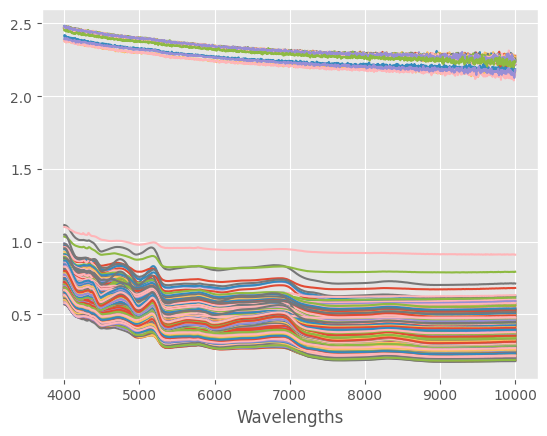

In [4]:
wave_columns = df.columns[4:]
wavelengths = [float(wavelength) for wavelength in wave_columns]

with plt.style.context('ggplot'):
    plt.plot(wavelengths,df[wave_columns].T)
    plt.xlabel("Wavelengths")
    plt.show()

In [5]:
wave_data = df[wave_columns].to_numpy()
correlation_matrix = np.corrcoef(wave_data, rowvar=False)
print(correlation_matrix)

[[1.         0.99999554 0.99998965 ... 0.89836731 0.89850287 0.8987331 ]
 [0.99999554 1.         0.99999686 ... 0.8982075  0.89834042 0.89856795]
 [0.99998965 0.99999686 1.         ... 0.89818143 0.89831233 0.89853876]
 ...
 [0.89836731 0.8982075  0.89818143 ... 1.         0.99998201 0.9999516 ]
 [0.89850287 0.89834042 0.89831233 ... 0.99998201 1.         0.99996964]
 [0.8987331  0.89856795 0.89853876 ... 0.9999516  0.99996964 1.        ]]


Highly correlated features.... luckly we can use PLS to reduce the dimensionality of the data...

# Partial Least Squares Regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from PLSR import MultiOutputPLSRegression

### Preprocessing the data

In [7]:
# Preparing data for optimization
ID = df['ID']
df_copy = df.dropna().drop(columns = 'ID')
Y = df_copy[df_copy.columns[0:3]]
X = df_copy[df_copy.columns[3:]]


# Scaling the data
X_scaler = StandardScaler()
Y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y) 

# Train Validation Test Split - 80% Train, 10% Validation, 10% Test
X_train,X_valtest,Y_train, Y_valtest = train_test_split(X_scaled,Y_scaled,test_size=0.3,random_state=42)
X_val,X_test,Y_val,Y_test = train_test_split(X_valtest,Y_valtest,test_size=0.5,random_state=42)


### Optimizing the number of components

In [8]:
# choose the maximum number of components to test
maximum_number_of_components = 50

# Initialize the multiPLSR model
multiPLSR = MultiOutputPLSRegression()

# Find the optimal number of components
multiPLSR.findOptimalNumberOfComponents(X_train,Y_train,X_val,Y_val,maximum_number_of_components)
print()


Optimizing Number of Components: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]

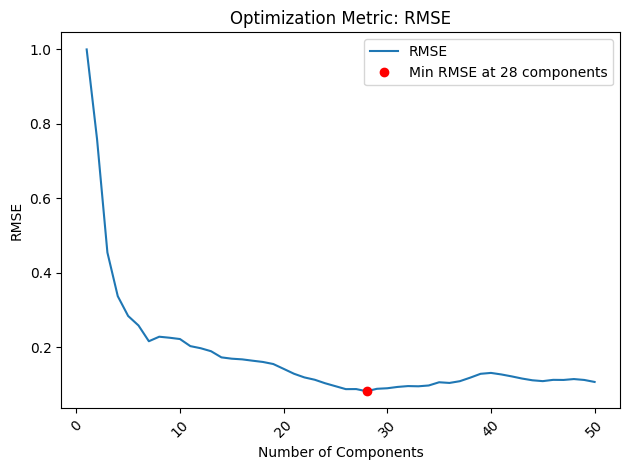

In [9]:
# Plot RMSE as a function of the number of components
multiPLSR.plotMetricResults()

### Training the model using CV-10

In [ ]:
optimal_n_components = 28
multiPLSR.crossValidation(X_train,Y_train, optimal_n_components)
print()

Cross Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


[0.04337171679367894,
 0.03146211440474137,
 0.041804648612013946,
 0.03686031778397749,
 0.05556579468889381,
 0.039546304194873885,
 0.05611548990774205,
 0.08839529094266586,
 0.0488714114502938,
 0.07496139033714813]

### Testing the model

In [21]:
Y_pred = multiPLSR.multiPLSR.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)

print(f' RMSE for N_value: {rmse[0]}\n RMSE for SC_Value: {rmse[1]}\n RMSE for ST_Value: {rmse[2]}\n Average RMSE: {np.mean(rmse)}')

 RMSE for N_value: 0.037250908356266446
 RMSE for SC_Value: 0.05323649388193664
 RMSE for ST_Value: 0.034268283821064775
 Average RMSE: 0.04158522868642262
